# **Jornadas de laboratorio en vacaciones: Un modelo de programación lineal**

Este trabajo aplicado de investigación de operaciones determinísticas busca formular y resolver un modelo de programación lineal para determinar el esquema óptimo de apertura de un laboratorio durante el periodo de vacaciones en la Universidad del Magdalena.

## **1. Descripción del problema**

### **1. 1. Contexto y restricciones**

1. **Restricción de personal:** No es viable contratar personal laboratorista. Como alternativa, se utilizará a la coordinadora de programa para desarrollar su jornada laboral en la sala, permitiendo así su activación.

2. **Limitación de uso:** Dado que el laboratorio no es el espacio habitual de la coordinadora, el espacio solo podrá habilitarse en 3 jornadas a lo largo de la semana.

3. **Condición diaria:** Solo se puede habilitar una jornada por día, ya sea en la mañana o en la tarde.

### **1. 2. Objetivo del modelo**

El objetivo principal es maximizar la demanda de uso del laboratorio por parte de los estudiantes, escogiendo las tres jornadas semanales, de un total de 12 posibles (Lunes a sábado, mañana y tarde), que generen la mayor satisfacción.

### **1. 3. Metodología de obtención de datos**

Dado que se desconoce la demanda, se plantea la siguiente solución:

1. **Sondeo a estudiantes:** Se realizará un sondeo para preguntar a los estudiantes en qué jornadas irían a la universidad a usar los laboratorios.

2. **Definición de coeficientes:** Los resultados de este sondeo establecerán los coeficientes de la función objetivo, representando la "demanda" de cada jornada.

## **2. Análisis de datos**

### **2. 1. Metodología del sondeo**

El objetivo de esta fase fue recolectar los datos de demanda estudiantil necesarios para establecer los coeficientes de la función objetivo.

Se utilizó Google Forms para estructurar las preguntas permitiendo a los estudiantes indicar su código estudiantil, nombre, y seleccionar todas las jornadas (mañana o tarde) entre las cuales estarían dispuestos a usar el laboratorio durante el periodo de vacaciones.

El enlace del formulario se compartió a través de grupos y comunidades de WhatsApp relevantes del Programa de Ingeniería de Sistemas de la universidad, asegurando que la muestra coincida con los usuarios de los laboratorios.

Una vez finalizado el periodo de recolección, los datos de respuesta se exportaron a un archivo Excel para su posterior análisis.

### **2.2. Descripción y análisis de datos**

En esta sección se procesan los datos del sondeo, el objetivo es cuantificar la demanda y medir el alcance.

In [1]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpBinary, LpMaximize, lpSum, value
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo xlsx
file_path = "../data/respuestas.xlsx"
df = pd.read_excel(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Marca temporal          125 non-null    datetime64[ns]
 1   codigo_estudiantil      125 non-null    int64         
 2   nombre_completo         125 non-null    object        
 3   disponibilidad_jornada  125 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.0+ KB


In [2]:
df.head()

,Marca temporal,codigo_estudiantil,nombre_completo,disponibilidad_jornada
0,2025-11-07 17:45:23.604,2023214016,Mauricio Ríos Cantillo,"Lunes tarde, Martes tarde, Miercoles tarde, Ju..."
1,2025-11-07 17:47:42.939,2023214074,José Bonett,"Lunes mañana, Lunes tarde, Martes mañana, Mart..."
2,2025-11-07 17:49:58.558,2024214003,German Andrés Rueda Pertuz,"Martes tarde, Miercoles mañana, Viernes mañana..."
3,2025-11-07 17:53:18.829,2024114075,Allan David Fernández Herazo,"Jueves tarde, Viernes tarde, Sabado tarde"
4,2025-11-07 18:38:31.556,2025214235,Jaime Alexander Alarcón Mejia,"Lunes tarde, Miercoles mañana, Viernes mañana,..."


> La columna "Marca temporal" no es visible en el archivo excel, se hizo **df.head()** para confirmar los valores de esta columna, y se comprueba que solo corresponde al momento en el que el estudiante diligenció el formulario.

Mantedremos la columna "codigo_estudiantil" como clave primaria para identificar estudiantes, para luego poder generar las variables del modelo y asignaciones.

Debido a que las columnas "Marca temporal" y "nombre_completo" no tienen una utílidad análitica, ni impacto en la construcción de las variables del modelo, serán excluidas del conjunto de datos antes de iniciar el análisis.

In [3]:
df = df.drop(columns=[
    "Marca temporal", 
    "nombre_completo"
    ])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   codigo_estudiantil      125 non-null    int64 
 1   disponibilidad_jornada  125 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


Se establece la lista completa de jornadas ofertadas en el sondeo. Esta lista servirá para estandarizar la limpieza y codificación de las respuestas.

In [4]:
jornadas_validas = [
    "Lunes mañana", "Lunes tarde",
    "Martes mañana", "Martes tarde",
    "Miercoles mañana", "Miercoles tarde",
    "Jueves mañana", "Jueves tarde",
    "Viernes mañana", "Viernes tarde",
    "Sabado mañana", "Sabado tarde"
]

df["disponibilidad_jornada"] = (
    df["disponibilidad_jornada"]
        .astype(str)
        .str.split(",")
        .apply(lambda lista: [x.strip() for x in lista])
)
df[["codigo_estudiantil", "disponibilidad_jornada"]].head()

,codigo_estudiantil,disponibilidad_jornada
0,2023214016,"[Lunes tarde, Martes tarde, Miercoles tarde, J..."
1,2023214074,"[Lunes mañana, Lunes tarde, Martes mañana, Mar..."
2,2024214003,"[Martes tarde, Miercoles mañana, Viernes mañan..."
3,2024114075,"[Jueves tarde, Viernes tarde, Sabado tarde]"
4,2025214235,"[Lunes tarde, Miercoles mañana, Viernes mañana..."


Para cada una de las jornadas se genera una columna binaria que indica si el estudiante seleccionó (1) o no seleccionó (0) dicha jornada.

In [5]:
for j in jornadas_validas:
    df[j] = df["disponibilidad_jornada"].apply(lambda lista: 1 if j in lista else 0)

df.head()

,codigo_estudiantil,disponibilidad_jornada,Lunes mañana,Lunes tarde,Martes mañana,Martes tarde,Miercoles mañana,Miercoles tarde,Jueves mañana,Jueves tarde,Viernes mañana,Viernes tarde,Sabado mañana,Sabado tarde
0,2023214016,"[Lunes tarde, Martes tarde, Miercoles tarde, J...",0,1,0,1,0,1,0,1,0,1,0,1
1,2023214074,"[Lunes mañana, Lunes tarde, Martes mañana, Mar...",1,1,1,1,1,1,1,1,1,1,1,1
2,2024214003,"[Martes tarde, Miercoles mañana, Viernes mañan...",0,0,0,1,1,0,0,0,1,1,1,1
3,2024114075,"[Jueves tarde, Viernes tarde, Sabado tarde]",0,0,0,0,0,0,0,1,0,1,0,1
4,2025214235,"[Lunes tarde, Miercoles mañana, Viernes mañana...",0,1,0,0,1,0,0,0,1,0,1,0


Se suman las variables binarias para determinar cuántos estudiantes seleccionaron cada jornada. También se geera un gráfico de barras para visualizar la demanda relativa. 

In [6]:
demanda = df[jornadas_validas].sum()
demanda_dict = demanda.to_dict()
demanda.sort_values(ascending=False)

Miercoles tarde     52
Jueves tarde        51
Martes tarde        50
Viernes tarde       49
Lunes tarde         43
Miercoles mañana    41
Jueves mañana       41
Martes mañana       40
Viernes mañana      39
Lunes mañana        34
Sabado tarde        23
Sabado mañana       21
dtype: int64

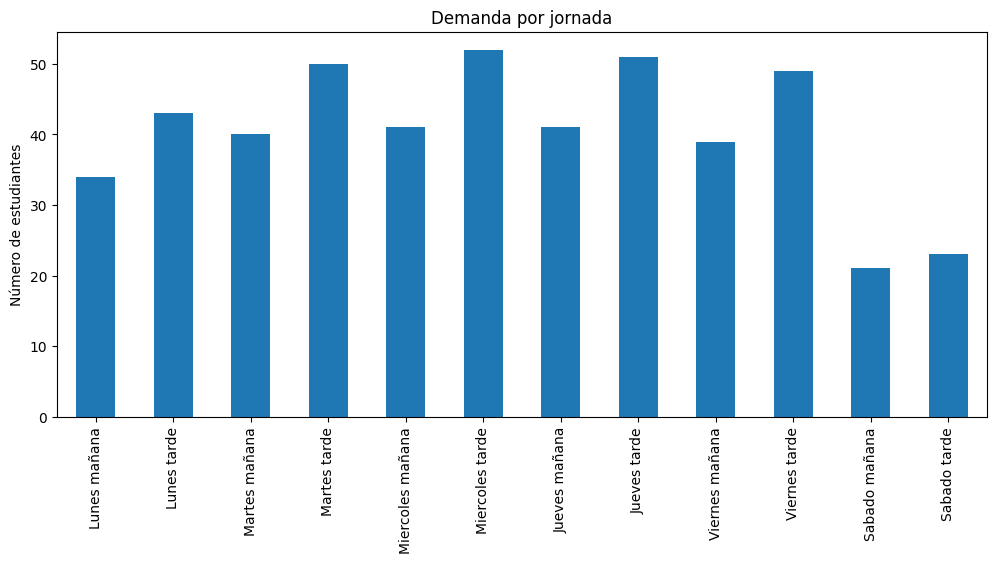

In [7]:
demanda.plot(kind="bar", figsize=(12,5))
plt.title("Demanda por jornada")
plt.ylabel("Número de estudiantes")
plt.savefig("../results/graficos/demanda_jornadas.png")
plt.show()

Calculamos el porcentaje de demanda relativa para evaluar la importancia de cada jornada respecto al total de estudiantes.

In [8]:
total = len(df)
porcentaje = (demanda / total * 100).sort_values(ascending=False)
porcentaje

Miercoles tarde     41.6
Jueves tarde        40.8
Martes tarde        40.0
Viernes tarde       39.2
Lunes tarde         34.4
Miercoles mañana    32.8
Jueves mañana       32.8
Martes mañana       32.0
Viernes mañana      31.2
Lunes mañana        27.2
Sabado tarde        18.4
Sabado mañana       16.8
dtype: float64

In [9]:
demanda.to_json("../results/tablas/demanda_jornadas.json")

## **3. Construcción del modelo**

La presente sección desarrollan los modelos utilizados para selecionar las jornadas óptimas de laboratorios. Se plantean dos enfoques:

1. **Maximizar la demanda**, es decir, elegir las jornadas con mayor número bruto de estudiantes interesados.

2. **Maximizar la cobertura estudiantil**, buscando que la mayor cantidad de estudiantes tenga al menos una jornada seleccionada dentro de sus disponibilidades.

Ambos modelos se implementan con PuLP, un solver de Programación Lineal Entera.

### **3.1. Modelo: Maximizar demanda total**

Este modelo selecciona exactamente tres jornadas, representadas mediantes variables binarias $x_{j} \in \{0,1\}$.

El objetivo consiste en maximizar la suma de las demandas, es decir, priorizar las franjas horarias donde más estudiantes indicaron disponibilidad.

#### **3.1.1. Definición de variables de decisión**

* $x_i$: Variable binaria que indica si la jornada $i$ es seleccionada.

    $$ x_i =
    \begin{cases}
    1 & \text{si la jornada } i \text{ es incluida en el plan} \\
    0 & \text{en caso contrario}
    \end{cases}
    $$

* **$D_i$**: Demanda asociada a la jornada $i$.
* **$C_i$**: Costo o recurso requerido por la jornada $i$.
* **$R$**: Límite total de recursos disponibles.

#### **3.1.2. Función objetivo**

$$
\max \sum_{i \in I} D_i \, x_i
$$

#### **3.1.3. Restricciones**

1. Límite de recursos
$$
\sum_{i \in I} C_i \, x_i \le R
$$

2. Solo 3 jornadas
$$
\sum_{i \in I} x_i = 3
$$

3. A lo sumo una jornada por día
$$
x_{d,\text{mañana}} + x_{d,\text{tarde}} \le 1 \quad \forall d \in D
$$


4. Variables binarias
$$
x_i \in \{0,1\} \quad \forall i \in I
$$

5. Al menos una jornada en la mañana
$$
\sum_{d \in D} x_{d,M} \ge 1
$$

6. Al menos una jornada en la tarde
$$
\sum_{d \in D} x_{d,T} \ge 1


#### **3.1.4. Implementación del modelo en PuLP**

In [10]:
# Crear el modelo
model = LpProblem("Maximizar_Demanda", LpMaximize)

# Preparar la serie de demanda
demanda_series = demanda

# Variables binarias por jornada
x = {j: LpVariable(f"x_{j.replace(' ', '_')}", cat=LpBinary) for j in demanda_series.index}

# Función objetivo
model += lpSum([demanda_series[j] * x[j] for j in demanda_series.index])

# Restricción: seleccionar exactamente 3 jornadas
model += lpSum([x[j] for j in demanda_series.index]) == 3

# Restricción: a lo sumo una jornada por día
dias = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado"]
for d in dias:
    m = f"{d} mañana"
    t = f"{d} tarde"
    if m in x and t in x:
        model += x[m] + x[t] <= 1

# Restricciones: al menos una mañana y una tarde
model += lpSum([x[j] for j in demanda_series.index if "mañana" in j]) >= 1
model += lpSum([x[j] for j in demanda_series.index if "tarde" in j]) >= 1

# Resolver
model.solve()

# Resultados
selected = [j for j in demanda_series.index if x[j].value() == 1]
print("Jornadas seleccionadas (demanda):", selected)
print("Demanda total:", value(model.objective))

# Guardar resultados
result_df = pd.DataFrame({
    "jornada": list(demanda_series.index),
    "demanda": list(demanda_series.values),
    "seleccionada": [int(x[j].value()) for j in demanda_series.index]
})
result_df.to_csv("../results/tablas/resultados_modelo_demanda.csv", index=False)
result_df

Jornadas seleccionadas (demanda): ['Martes mañana', 'Miercoles tarde', 'Jueves tarde']
Demanda total: 143.0


,jornada,demanda,seleccionada
0,Lunes mañana,34,0
1,Lunes tarde,43,0
2,Martes mañana,40,1
3,Martes tarde,50,0
4,Miercoles mañana,41,0
5,Miercoles tarde,52,1
6,Jueves mañana,41,0
7,Jueves tarde,51,1
8,Viernes mañana,39,0
9,Viernes tarde,49,0


### **3.2. Modelo: Maximizar cobertura de estudiantes**

Este modelo busca seleccionar tres jornadas de tal forma que se cubra el mayor número posible de estudiantes, donde “cubrir” a un estudiante significa que al menos una de las jornadas seleccionadas coincide con su disponibilidad.

A diferencia del modelo de maximización de demanda —que suma disponibilidades— este modelo considera cobertura individual: un estudiante cuenta como cubierto una sola vez independientemente de cuántas jornadas seleccionadas coincidan con su disponibilidad.

#### **3.2.1. Definición de variables de decisión**

* **$x_j$**: Variable binaria que indica si la jornada $j$ es seleccionada.

  $$
  x_j =
  \begin{cases}
  1 & \text{si la jornada } j \text{ es seleccionada} \\
  0 & \text{en caso contrario}
  \end{cases}
  $$

* **$z_i$**: Variable binaria que indica si el estudiante $i$ está cubierto por al menos una de las jornadas seleccionadas.

  $$
  z_i =
  \begin{cases}
  1 & \text{si el estudiante } i \text{ queda cubierto} \\
  0 & \text{si no está cubierto}
  \end{cases}
  $$

* **$A_{i,j}$**: Parámetro que vale:
  $$
  A_{i,j} =
  \begin{cases}
  1 & \text{si el estudiante } i \text{ está disponible en la jornada } j \\
  0 & \text{en caso contrario}
  \end{cases}
  $$

#### **3.2.2. Función objetivo**

Maximizar la cantidad total de estudiantes cubiertos:

$$
\max \sum_{i \in I} z_i
$$

#### **3.2.3. Restricciones**

1. **Cobertura por disponibilidad**

Un estudiante se marca como cubierto solo si al menos una jornada seleccionada coincide con su disponibilidad:

$$
\sum_{j \in J} A_{i,j} \, x_j \ge z_i \quad \forall i \in I
$$

2. **Seleccionar exactamente 3 jornadas**

$$
\sum_{j \in J} x_j = 3
$$

3. **A lo sumo una jornada por día**

$$
x_{d,\text{mañana}} + x_{d,\text{tarde}} \le 1 \quad \forall d \in D
$$

4. **Al menos una jornada en la mañana**

$$
\sum_{d \in D} x_{d,M} \ge 1
$$

5. **Al menos una jornada en la tarde**

$$
\sum_{d \in D} x_{d,T} \ge 1
$$

6. **Variables binarias**

$$
x_j \in \{0,1\}, \qquad z_i \in \{0,1\}
$$

#### **3.2.4. Implementación del modelo en PuLP**

In [11]:
# Crear el modelo
model2 = LpProblem("Maximizar_Cobertura", LpMaximize)

# Jornadas válidas
J = jornadas_validas

# Estudiantes
I = df.index

# Matriz A_{i,j}: disponibilidad del estudiante i en la jornada j
A = {
    (i, j): int(df.loc[i, j])
    for i in I
    for j in J
}

# Variables x_j (selección de jornadas)
x2 = {j: LpVariable(f"x2_{j.replace(' ','_')}", cat=LpBinary) for j in J}

# Variables z_i (estudiante cubierto)
z = {i: LpVariable(f"z_{i}", cat=LpBinary) for i in I}

# Función objetivo
model2 += lpSum([z[i] for i in I])

# Restricción de cobertura por estudiante
for i in I:
    model2 += lpSum([A[(i,j)] * x2[j] for j in J]) >= z[i]

# Selección de exactamente 3 jornadas
model2 += lpSum([x2[j] for j in J]) == 3

# A lo sumo una jornada por día
dias = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado"]
for d in dias:
    m = f"{d} mañana"
    t = f"{d} tarde"
    if m in x2 and t in x2:
        model2 += x2[m] + x2[t] <= 1

# Al menos una mañana
model2 += lpSum([x2[j] for j in J if "mañana" in j]) >= 1

# Al menos una tarde
model2 += lpSum([x2[j] for j in J if "tarde" in j]) >= 1

# Resolver
model2.solve()

# Resultados
selected2 = [j for j in J if x2[j].value() == 1]
print("Jornadas seleccionadas (cobertura):", selected2)
print("Estudiantes cubiertos:", value(model2.objective))

# Guardar resultados
result_cov = pd.DataFrame({
    "jornada": list(J),
    "seleccionada": [int(x2[j].value()) for j in J]
})
result_cov.to_csv("../results/tablas/resultados_modelo_cobertura.csv", index=False)
result_cov

Jornadas seleccionadas (cobertura): ['Martes tarde', 'Jueves mañana', 'Viernes tarde']
Estudiantes cubiertos: 94.0


,jornada,seleccionada
0,Lunes mañana,0
1,Lunes tarde,0
2,Martes mañana,0
3,Martes tarde,1
4,Miercoles mañana,0
5,Miercoles tarde,0
6,Jueves mañana,1
7,Jueves tarde,0
8,Viernes mañana,0
9,Viernes tarde,1


### **3.4. Análisis de los resultados**



In [12]:
# Métricas del modelo de demanda
demanda_total_objetivo = value(model.objective)

covered_by_model1 = 0
for i in df.index:
    for j in selected:
        if df.loc[i, j] == 1:
            covered_by_model1 += 1
            break

# Métricas del modelo de cobertura
estudiantes_cubiertos_model2 = value(model2.objective)
demanda_model2 = demanda.loc[selected2].sum()

# Tabla comparativa
comparacion = pd.DataFrame({
    "modelo": ["Maximizar demanda", "Maximizar cobertura"],
    "demanda_total": [demanda_total_objetivo, demanda_model2],
    "estudiantes_cubiertos": [covered_by_model1, estudiantes_cubiertos_model2],
    "jornadas_seleccionadas": [selected, selected2]
})

comparacion.to_csv("../results/tablas/comparacion_modelos.csv", index=False)

comparacion

,modelo,demanda_total,estudiantes_cubiertos,jornadas_seleccionadas
0,Maximizar demanda,143.0,89.0,"[Martes mañana, Miercoles tarde, Jueves tarde]"
1,Maximizar cobertura,140.0,94.0,"[Martes tarde, Jueves mañana, Viernes tarde]"


Los resultados muestran que ambos modelos priorizan criterios diferentes y, por lo tanto, ofrecen soluciones similares, pero no equivalentes. El modelo que maximiza la demanda selecciona los horarios con mayor capacidad disponible, logrando así la mayor demanda (143), pero a costa de un menor apoyo individualizado, ya que solo se puede atender a 89 estudiantes. El modelo que maximiza el apoyo, en cambio, prioriza la inclusión del mayor número posible de estudiantes de diversos orígenes, incluso si esto implica seleccionar grupos con una demanda relativa menor. Esto se traduce en un mayor apoyo (94 estudiantes), aunque la demanda total sea algo menor (140). En la práctica, la primera estrategia favorece la eficiencia general del recurso, mientras que la segunda promueve la igualdad de oportunidades al incluir a más estudiantes, lo que pone de manifiesto la disyuntiva entre el número total de estudiantes atendidos y la diversidad individual de quienes reciben apoyo.